<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Разделение-на-выборки-и-признаки" data-toc-modified-id="Разделение-на-выборки-и-признаки-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Разделение на выборки и признаки</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выбор-лучшей-модели" data-toc-modified-id="Выбор-лучшей-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выбор лучшей модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача:** Обучить модель классифицировать комментарии на позитивные и негативные со значением метрики качества *F1* не меньше 0.75. 

Заказчик предоставил набор данных с разметкой о токсичности правок.


**План работы**

1. Загрузка и подготовка данных.
2. Обучение моделей логистической регрессии, дерева решений, cat-бустинга и LightGBM. 
3. Выбор лучшей модели и проверка на тестовой выборке. 
3. Общий вывод.

**Описание данных**

Столбец *text* содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 640.0 kB/s eta 0:00:20
     ---------------------------------------- 0.2/12.8 MB 1.5 MB/s eta 0:00:09
     - -------------------------------------- 0.4/12.8 MB 2.9 MB/s eta 0:00:05
     -- ------------------------------------- 0.9/12.8 MB 5.3 MB/s eta 0:00:03
     ----- ---------------------------------- 1.7/12.8 MB 7.0 MB/s eta 0:00:02
     ------- -------------------------------- 2.4/12.8 MB 8.6 MB/s eta 0:00:02
     ---------- ----------------------------- 3.2/12.8 MB 10.3 MB/s eta 0:00:01
     ------------ --------------------------- 4.0/12.8 MB 11.0 MB/s eta 0:00:01
     -------------- ------------------------- 4.7/12.8 MB 11.2 MB/s eta 0:00:01
     ----------------- ---------------------- 5.6/12.8 MB 12.3 MB/s eta 0:00:01
     -------------------- ------------------- 6.4/12.8 MB 12.8 MB/s eta 0:00:01
     ---------------------- ----------------- 7.1/12.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy


from tqdm import tqdm

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [3]:
data = pd.read_csv('toxic_comments.csv')

### Предобработка данных

In [4]:
# обзор данных 

data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [5]:
# проверка дубликатов и пропусков

print('Количество дубликатов:', data.duplicated().sum())
print('Количество пропусков:', data.isna().sum())

Количество дубликатов: 0
Количество пропусков: Unnamed: 0    0
text          0
toxic         0
dtype: int64


In [6]:
# удаление неактуального столбца

data = data.drop('Unnamed: 0', axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [7]:
# приведение текста к нижнему регистру

data['text'] = data['text'].str.lower()

data.head()

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0


toxic
0    143106
1     16186
Name: count, dtype: int64

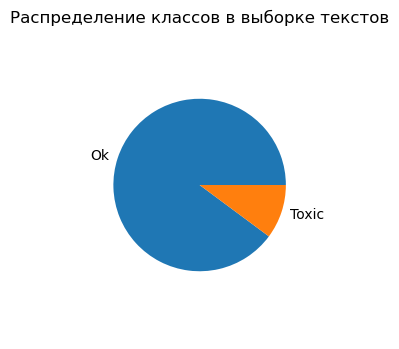

In [8]:
# исследование баланса классов

display(data['toxic'].value_counts())

value_counts = data['toxic'].value_counts()

plt.figure(figsize=(4,4))
plt.pie(value_counts, radius = 0.7,labels=['Ok', 'Toxic'])
plt.title('Распределение классов в выборке текстов')
plt.ylabel(None)
plt.show();

В ходе предобработки были проанализированы:
1. Содержание датафрейма - показало наличие в таблице релевантных данных, за исключением одного столбца, содержащего неидентифицированные данные, который был удален.
2. Пропуски и дубликаты - отсуствовали в датафрейме.
3. Содержание датафрейма - было приведено к строчному регистру.
4. Баланс классов - наблюдается ярко выраженный дисбаланс.

### Лемматизация

In [9]:
# очищение текста от лишних символов

def clear_text(text):
    clear_list = re.sub(r'[^a-zA-Z ]', ' ', text)
    clear_text = " ".join(clear_list.split())
    return clear_text

data['text'] = data['text'].apply(clear_text)

In [10]:
# по комментарию ревьюера использован SpaCy

nlp = spacy.load('en_core_web_sm')

#предложения для тестирования
sentence = "The striped bats are hanging on their feet for best"
doc = nlp(sentence)
" ".join([token.lemma_ for token in doc])


'the stripe bat be hang on their foot for good'

In [11]:
# функция для SpaCy
def lemmatize(text):
    doc = nlp(text)
    lemm_list = [token.lemma_ for token in doc]
    lemm_text = " ".join(lemm_list)
    return lemm_text

# добавление лемм
tqdm.pandas()
data['lemm_text'] = data['text'].progress_apply(lemmatize)

100%|██████████████████████████████████████████████████████████████████████████| 159292/159292 [37:41<00:00, 70.42it/s]


In [12]:
# проверка дубликатов

print('Количество дубликатов:', data.duplicated().sum())
print()
data.info()

Количество дубликатов: 1294

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       159292 non-null  object
 1   toxic      159292 non-null  int64 
 2   lemm_text  159292 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


In [13]:
# исключение дубликатов

data = data.drop('text', axis=1)
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157976 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   toxic      157976 non-null  int64 
 1   lemm_text  157976 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [14]:
data.head()

,toxic,lemm_text
0,0,explanation why the edit make under my usernam...
1,0,d aww he match this background colour I m seem...
2,0,hey man I m really not try to edit war it s ju...
3,0,more I can t make any real suggestion on impro...
4,0,you sir be my hero any chance you remember wha...


Добавлен столбец с лемматизированным текстом, а также удалены дубликаты после лемматизаци и столбец с исходным текстом комментариев.

### Разделение на выборки и признаки

In [15]:
# разделение на обучающую, валидационную и тестовую выборки в соотношении 3:1:1

val_train, test = train_test_split(data, test_size=0.2, random_state=12345)
train, valid = train_test_split(val_train, test_size=0.25, random_state=12345)

train.shape, valid.shape, test.shape

((94785, 2), (31595, 2), (31596, 2))

In [16]:
# разделение на признаки и создание корпусов

features_train = train['lemm_text'].values
target_train = train['toxic']

features_valid = valid['lemm_text'].values
target_valid = valid['toxic'] 

features_test = test['lemm_text'].values
target_test = test['toxic']

features_train.shape, target_train.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape

((94785,), (94785,), (31595,), (31595,), (31596,), (31596,))

In [17]:
# TF-IDF для текстов, с учетом стоп-слов

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords) 
tf_idf_train = count_tf_idf.fit_transform(features_train) 
tf_idf_valid = count_tf_idf.transform(features_valid) 
tf_idf_test = count_tf_idf.transform(features_test) 

print('Размер матрицы:', tf_idf_train.shape)
print('Размер матрицы:', tf_idf_valid.shape) 
print('Размер матрицы:', tf_idf_test.shape)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Размер матрицы: (94785, 112154)
Размер матрицы: (31595, 112154)
Размер матрицы: (31596, 112154)


Данные разделены разделение на обучающую, валидационную и тестовую выборки в соотношении 3:1:1, в каждой выборке выделены параметр в формате корпуса текста и целевой признак. Для параметров в выборках рассчитан TF-IDF матрицы.

## Обучение

In [18]:
%%time

# обучение модели логистической регрессии

model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_lr.fit(tf_idf_train, target_train)
predictions_lr_valid = model_lr.predict(tf_idf_valid)
f1_score_lr = f1_score(target_valid, predictions_lr_valid).round(3)
print('F1 логистической регрессии на валидационной выборке:', f1_score_lr)

F1 логистической регрессии на валидационной выборке: 0.732
CPU times: total: 7.14 s
Wall time: 3.34 s


Модель логистической регресии на валидационных данных не показала минимально необходимой величины F1-меры - 0.732 ниже требуемых 0.75, поэтому обучим следующую модель.

In [19]:
%%time

# обучение модели дерева решений и поиск оптимальной глубины

best_model = None
best_result = 0 
best_depth = 0
for depth in range(10, 31):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dt.fit(tf_idf_train, target_train) 
    predictions_dt_valid = model_dt.predict(tf_idf_valid)
    result_dt = f1_score(target_valid, predictions_dt_valid) 
    if result_dt > best_result:
        best_model = model_dt
        best_result_dt = result_dt
        best_depth_dt = depth

print('F1 модели дерева решений на валидационной выборке:', best_result_dt.round(3), 'Глубина дерева:', best_depth_dt)

F1 модели дерева решений на валидационной выборке: 0.699 Глубина дерева: 30
CPU times: total: 2min 55s
Wall time: 4min 23s


Модель дерева решений на валидационных данных не показала минимально необходимой величины F1-меры - 0.699 ниже требуемых 0.75, поэтому обучим следующую модель.

In [20]:
%%time

# обучение модели cat-бустинга

model_cb = CatBoostClassifier(loss_function="Logloss", iterations=50)
model_cb.fit(tf_idf_train, target_train, verbose=10)
predictions_cb_valid = model_cb.predict(tf_idf_valid)
f1_score_cb = f1_score(target_valid, predictions_cb_valid).round(3)
print('F1 cat-бустинга на валидационной выборке:', f1_score_cb)

Learning rate set to 0.5
0:	learn: 0.3551919	total: 1.08s	remaining: 53.2s
10:	learn: 0.1804782	total: 9.18s	remaining: 32.6s
20:	learn: 0.1603798	total: 17.3s	remaining: 23.9s
30:	learn: 0.1479137	total: 25s	remaining: 15.3s
40:	learn: 0.1389934	total: 32.9s	remaining: 7.23s
49:	learn: 0.1330212	total: 40.3s	remaining: 0us
F1 cat-бустинга на валидационной выборке: 0.733
CPU times: total: 3min 30s
Wall time: 47.3 s


Модель cat-бустинга на валидационных данных не показала минимально необходимой величины F1-меры - 0.733 ниже требуемых 0.75, поэтому обучим следующую модель.

In [24]:
%%time

# обучение модели LightGBM

model_lgbm = LGBMClassifier(verbose=-1, learning_rate=0.1, num_leaves=100, random_state=12345)
model_lgbm.fit(tf_idf_train, target_train)
predictions_lgbm_valid = model_lgbm.predict(tf_idf_valid)
f1_score_lgbm = f1_score(target_valid, predictions_lgbm_valid).round(3)
print('F1 модели lgbm на валидационной выборке:', f1_score_lgbm)

F1 модели lgbm на валидационной выборке: 0.777
CPU times: total: 1min 21s
Wall time: 35.3 s


Модель lgbm на валидационных данных показала минимально необходимую величину F1-меры - 0.777 выше требуемых 0.75.

In [26]:
# подготовка сводной таблицы результатов

result = pd.DataFrame({
    'F1_score': [f1_score_lgbm, f1_score_cb, f1_score_lr, best_result_dt],
    },
    index=['LGBMClassifier', 'CatBoost', 'LogisticRegression', 'DecisionTree']
)
pd.set_option('display.max_colwidth', None)
result

,F1_score
LGBMClassifier,0.777000
CatBoost,0.733000
LogisticRegression,0.732000
DecisionTree,0.699343


Самый высокий результат f1-меры на валидационных данных показала модель lgbm - 0.777, что выше требуемых 0.75, поэтому проверим данную модель на тестовой выборке.

## Выбор лучшей модели

In [23]:
# проверка модели lgbm на тестовой выборке

predictions_lgbm_test = model_lgbm.predict(tf_idf_test)
print('F1 модели lgbm на тестовой выборке:', f1_score(target_test, predictions_lgbm_test).round(3))

F1 модели lgbm на тестовой выборке: 0.773


Модель lgbm на тестовых данных также показала величину F1-меры выше требуемых 0.75, а именно 0.773, поэтому рекомендуем заказчику внедрить данную модель.

## Выводы

Интернет-магазин «Викишоп» запускает новый сервис, позволяющих пользоватям редактировать и дополнять описания товаров, как в вики-сообществах, то есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Задача: Обучить модель классифицировать комментарии на позитивные и негативные со значением метрики качества F1 не меньше 0.75.

Заказчик предоставил набор данных с разметкой о токсичности правок.

**В ходе подготовки данных** были проанализированы:

1. Содержание датафрейма - показало наличие в таблице релевантных данных, за исключением одного столбца, содержащего неидентифицированные данные, который был удален.
2. Пропуски и дубликаты - отсуствовали в датафрейме.
3. Содержание датафрейма - было приведено к строчному регистру.
4. Баланс классов - наблюдается ярко выраженный дисбаланс.
5. Добавлен столбец с лемматизированным текстом, а также удалены дубликаты после лемматизаци и столбец с исходным текстом комментариев.

Для последующего обучения и выбора моделей данные были разделены разделение на обучающую, валидационную и тестовую выборки в соотношении 3:1:1, в каждой выборке выделены параметр в формате корпуса текста и целевой признак. Для параметров в выборках рассчитан TF-IDF матрицы.

**В рамках обучения** были исследованы следующие модели, показавшие результаты F1-меры:

| |F1-score|
|:-|:--------:|
|LGBMClassifier|	0.777|
|CatBoost|	0.733|
|LogisticRegression|	0.732|
|DecisionTree|	0.699|

Модель LightGBM смогла обучиться и достичь требуемого показателя F1-меры в 0.78 на валидационной выборке, поэтому данная модель была использована для проверки качества на тестовой выборке.

**В ходе тестирования** модель lgbm также показала величину F1-меры выше требуемых 0.75, а именно 0.773 на тестовых данных, поэтому рекомендуем заказчику внедрить данную модель.